In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error #不太靠谱 太劲大求了。差的平方的均值
from sklearn.metrics import explained_variance_score #越小代表结果越差
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #交叉验证
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import DecisionTreeRegressor
import matplotlib.dates as mdate
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
X = pd.read_excel('./input.xlsx')
#X['dayofyear'] = X['日期'].apply(lambda x : x.dayofyear)
X = X.loc[:1062]

c:\python3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
X.head()

,日期,星期,月份,四季,24节气,最高气温,最低气温,平均气温,温度等级,天气,...,PM10,SO2,CO,NO2,O3_8h,平均相对湿度,湿度等级,海平面大气压力,节假日,总供水量
0,2015-11-03,星期二,11,冬,普通,21,13,17.0,较低温,多云,...,106,21,1.4,84,112,72.0,较潮湿,1027.0,上班,4363379
1,2015-11-04,星期三,11,冬,普通,21,16,18.5,较低温,小雨,...,51,13,0.8,55,67,87.0,潮湿,1023.6,上班,4730486
2,2015-11-05,星期四,11,冬,普通,24,18,21.0,舒适偏冷,多云,...,66,18,0.8,58,64,87.0,潮湿,1020.8,上班,4488866
3,2015-11-06,星期五,11,冬,普通,24,19,21.5,舒适偏冷,小雨,...,37,13,0.6,34,75,84.0,潮湿,1017.8,上班,4546968
4,2015-11-07,星期六,11,冬,立冬,25,16,20.5,舒适偏冷,雷阵雨,...,52,16,1.1,39,48,90.0,潮湿,1018.5,周末,4344288


In [3]:
X['year'] = X['日期'].apply(lambda x : x.year)
X['dayofweek'] =  X['日期'].apply(lambda x: x.dayofweek)
X['dayofmonth'] = X['日期'].apply(lambda x: x.day)
X['前一天供水量'] = X['总供水量'].shift(1)
X['再往前一天供水量'] = X['总供水量'].shift(2)
X['与前一天空气质量差'] = X['空气质量指数'] - X['空气质量指数'].shift(1)
X['与前一天湿度差值'] = X['平均相对湿度'] - X['平均相对湿度'].shift(1)
X['与前一天最低气温差'] = X['最低气温'] - X['最低气温'].shift(1)
X['与前一天最高气温差'] = X['最高气温'] - X['最高气温'].shift(1)
X['与前一天平均温度差'] = X['平均气温'] - X['平均气温'].shift(1)

In [4]:
X = X[~pd.isnull(X['再往前一天供水量'])]
y = X.pop('总供水量')
date = X['日期']
drop = ['日期','星期','24节气','PM2.5','PM10','SO2','CO','NO2','O3_8h']
X.drop(drop,axis = 1,inplace = True)
X_reset = X.reset_index(drop = True)

In [5]:
sunday_index = X_reset.loc[X_reset['节假日'] == '周末'].index
for i in sunday_index:
    if X_reset.loc[i,'dayofweek'] == 6:
         X_reset.loc[i,'节假日'] = '周日'
    if X_reset.loc[i,'dayofweek'] == 5:
         X_reset.loc[i,'节假日'] = '周六'
X_input = pd.get_dummies(X_reset)

In [53]:
len(X_test)

64

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X_input,y,test_size = 0.06)

## 随机森林

In [7]:
from sklearn.ensemble import RandomForestRegressor
clf_fr = RandomForestRegressor(n_estimators=75)
test_score = -cross_val_score(clf_fr, X_input, y, cv=10, scoring='neg_mean_absolute_error')
print(np.mean(test_score))

81170.78187327339


71242.67291666666
0.016516679238519988


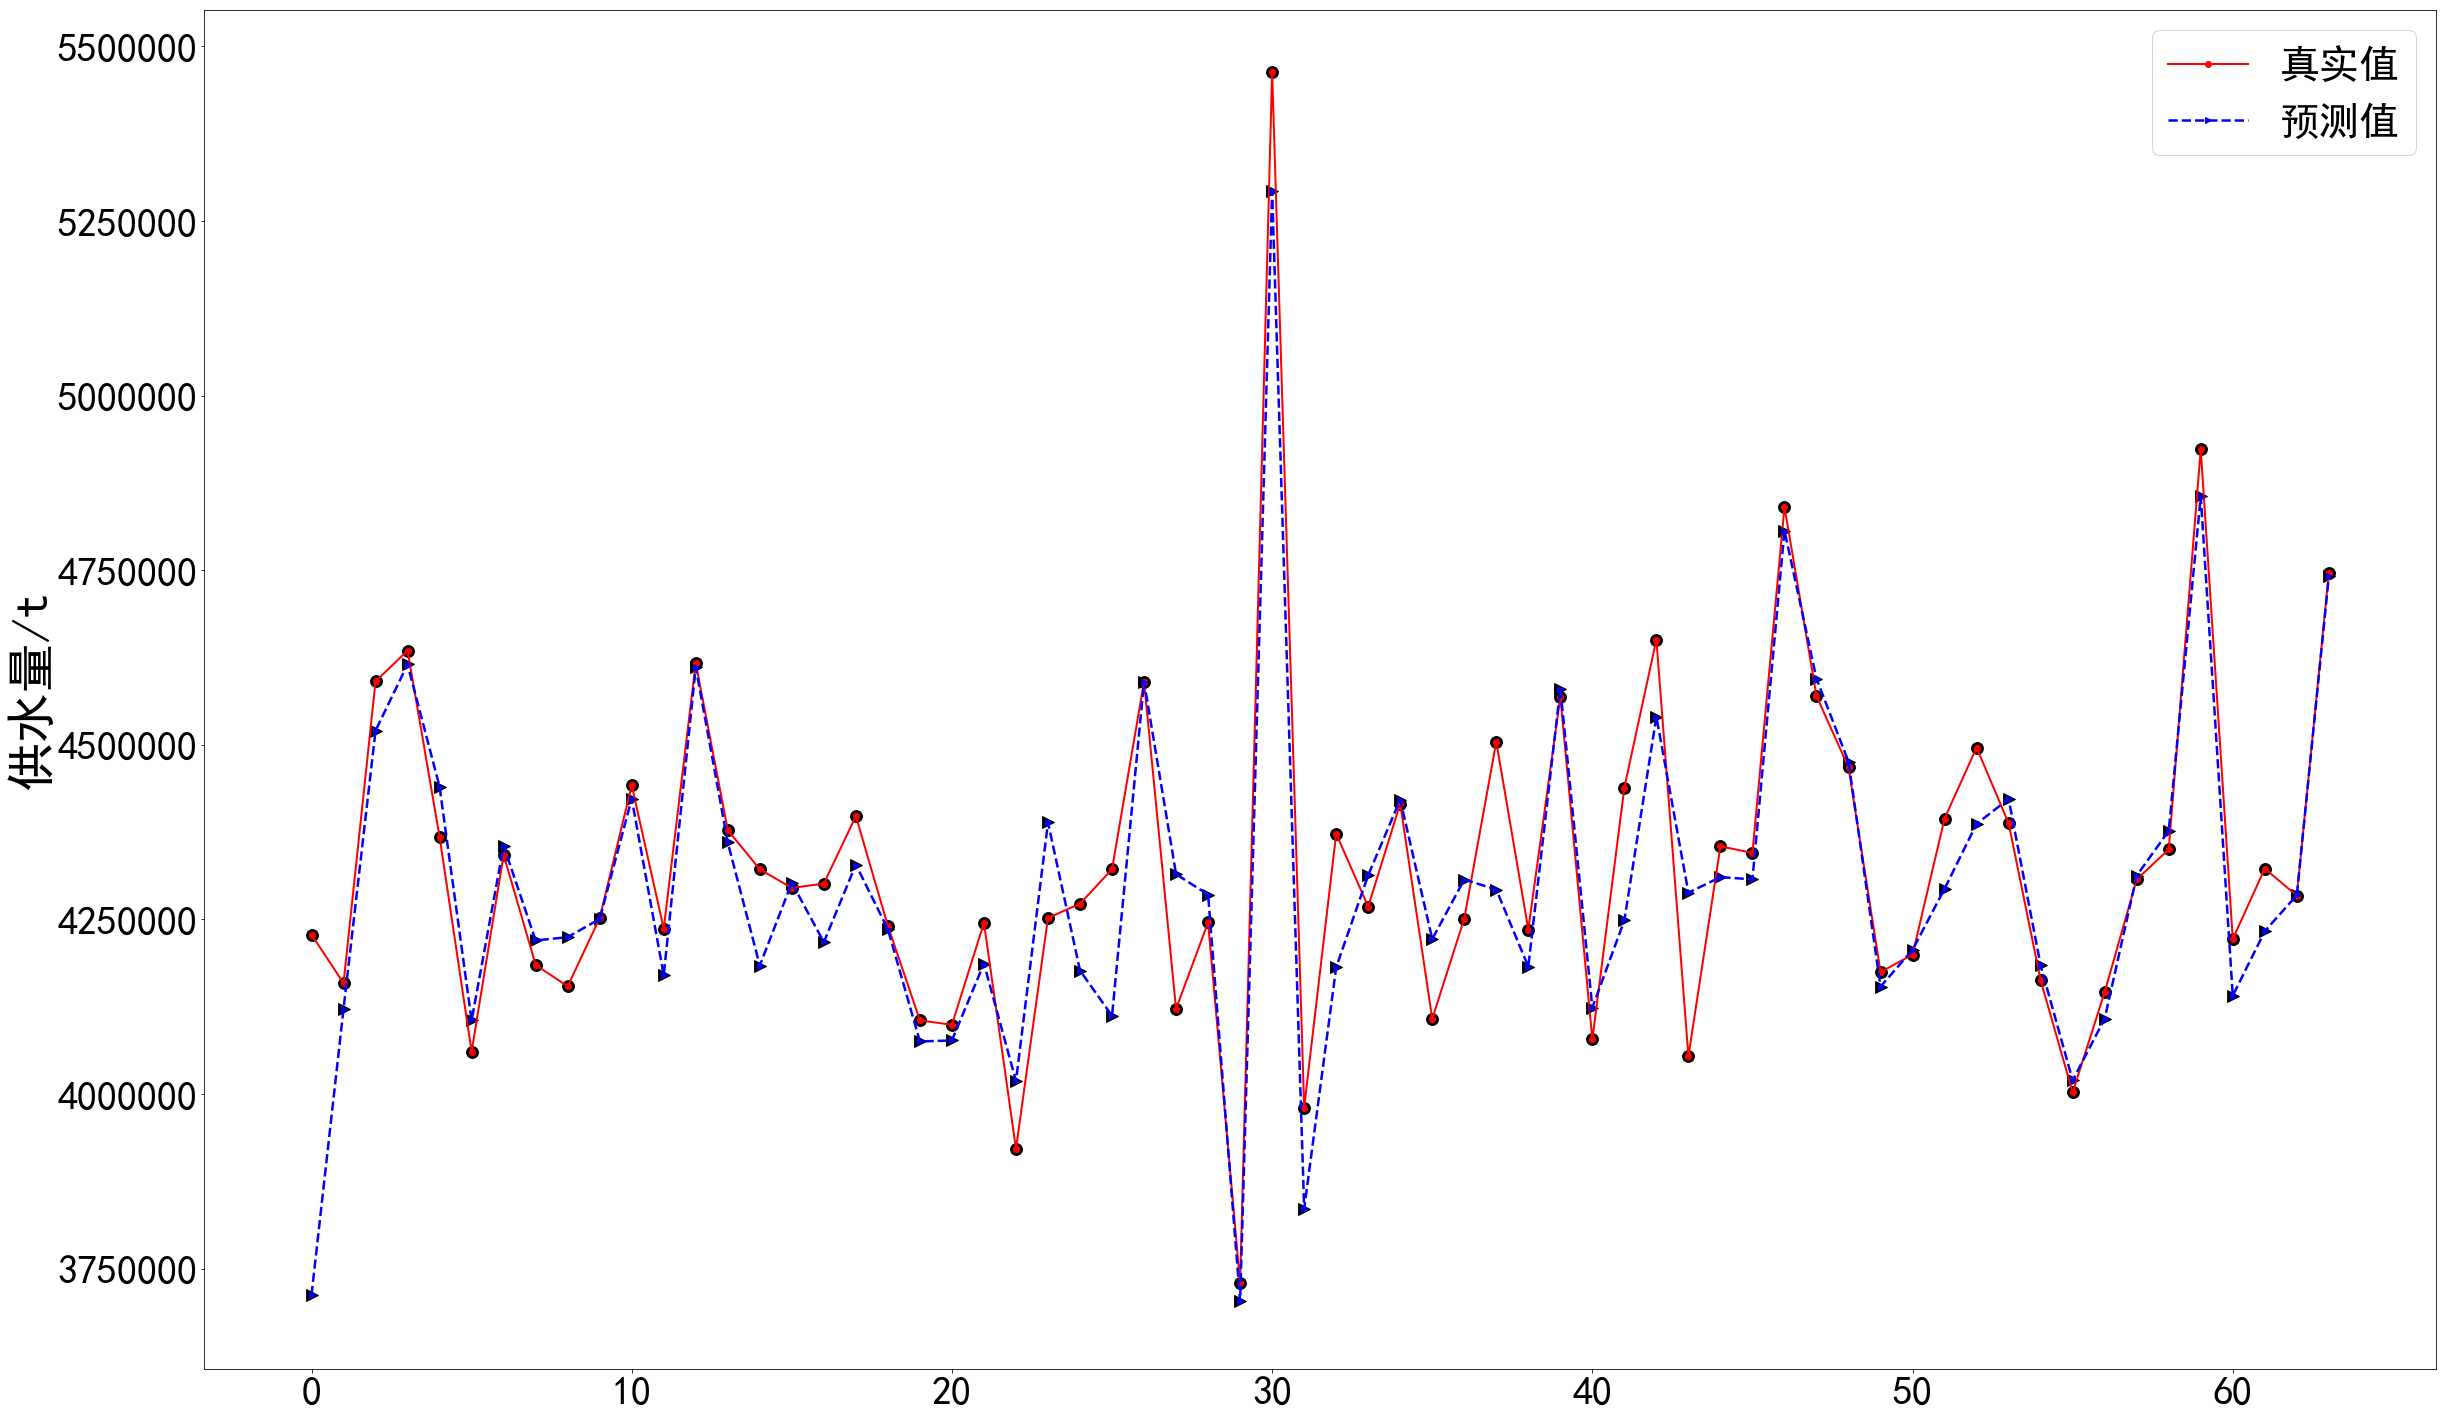

In [38]:
plt_model = RandomForestRegressor(n_estimators=75)
plt_model.fit(X_train,y_train)
y_new_pre = plt_model.predict(X_test)
fig1 = plt.figure(figsize=(40,25))
plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_new_pre,s= 140,color = 'black',marker = '>')
plt.plot(range(len(X_test)),y_test.values,'ro-',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_new_pre,'b>--',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.ylabel('供水量/t',size = 50)
plt.legend(prop={'size':40}) 
print(np.mean(abs(y_test-y_new_pre)))
print(np.mean(abs(y_test - y_new_pre)/y_test))

## AdaBoostRegressor

In [27]:
from sklearn.ensemble import AdaBoostRegressor
clf = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
test_score = -cross_val_score(clf, X_input, y, cv=10, scoring='neg_mean_absolute_error')
print(np.mean(test_score))

72218.80077367308


Text(0.5,1,'决策树平均偏差')

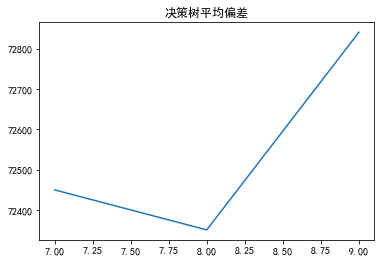

In [9]:
from sklearn.ensemble import AdaBoostRegressor
ada_params = [7,8,9]
ada_scores = []
for par in ada_params:
    clf = AdaBoostRegressor(n_estimators = par,base_estimator =  xgb.XGBRegressor())
    test_score = -cross_val_score(clf,X_input,y,scoring = 'neg_mean_absolute_error',cv = 10)
    ada_scores.append(np.mean(test_score))
plt.plot(ada_params, ada_scores)
plt.title("决策树平均偏差")

65814.51171875
0.015146272419402146


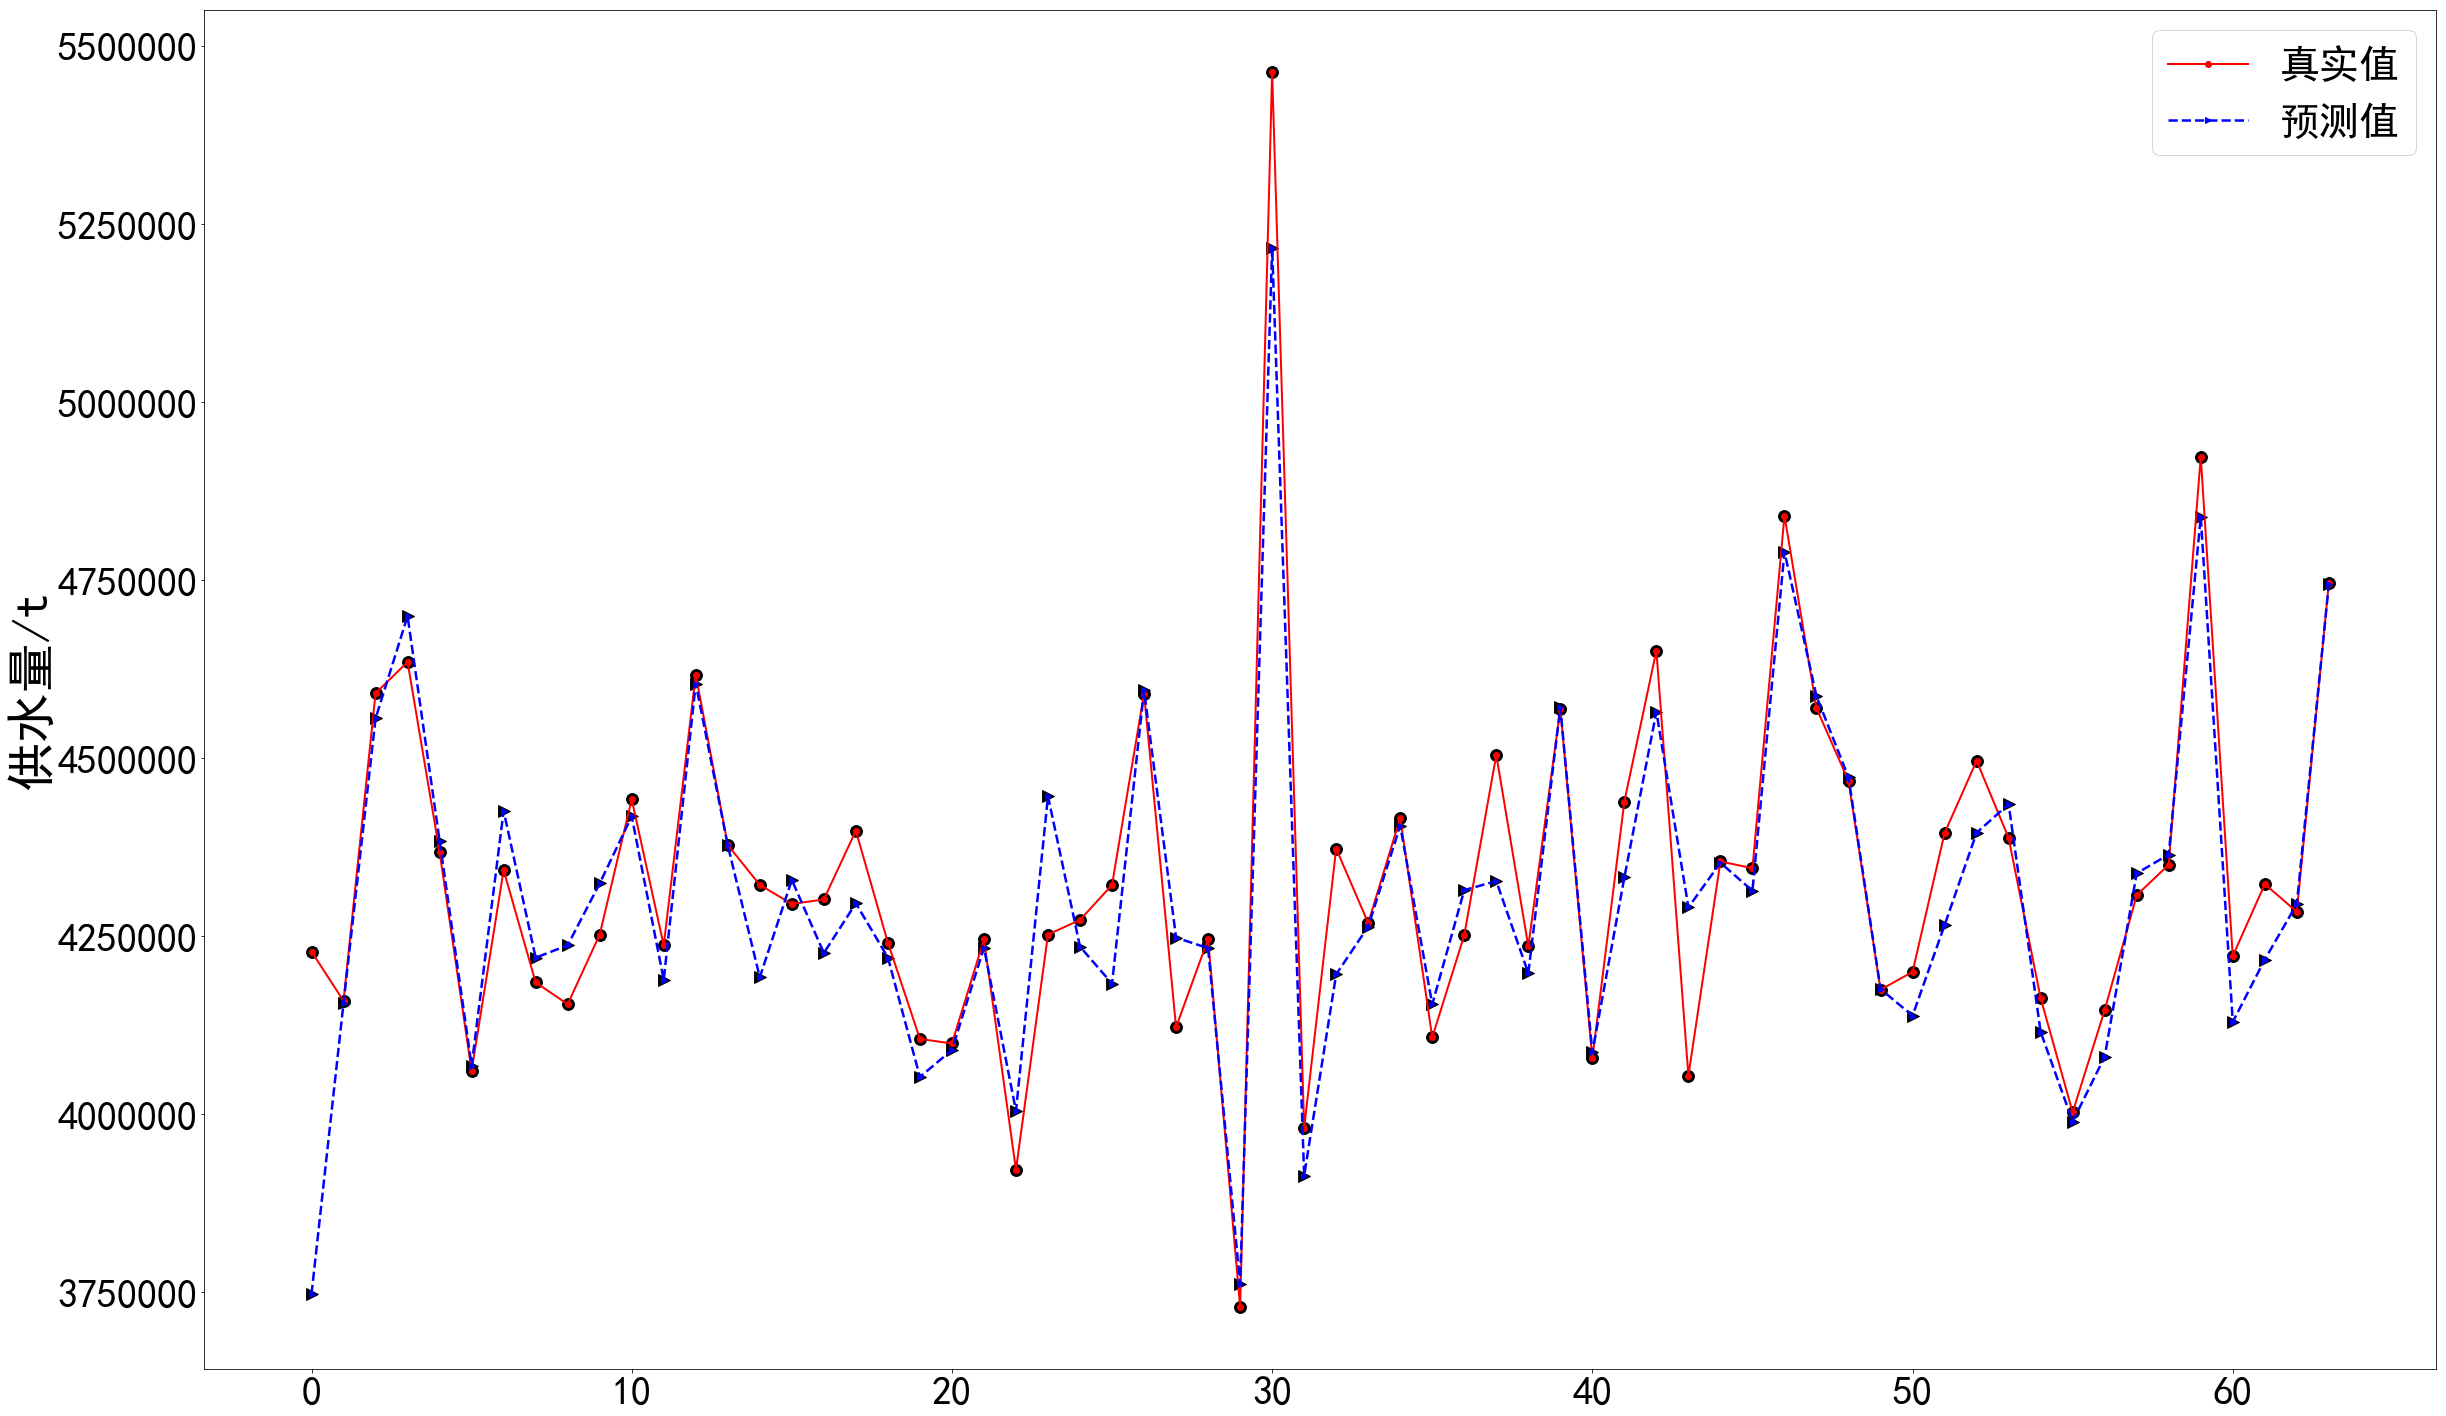

In [40]:
plt_model = AdaBoostRegressor(n_estimators = 8,base_estimator =  xgb.XGBRegressor())
plt_model.fit(X_train,y_train)
y_new_pre = plt_model.predict(X_test)
fig1 = plt.figure(figsize=(40,25))
plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_new_pre,s= 140,color = 'black',marker = '>')
plt.plot(range(len(X_test)),y_test.values,'ro-',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_new_pre,'b>--',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.ylabel('供水量/t',size = 50)
plt.legend(prop={'size':40}) 
print(np.mean(abs(y_test-y_new_pre)))
print(np.mean(abs(y_test - y_new_pre)/y_test))

## 决策树

In [8]:
from sklearn.tree import DecisionTreeRegressor
regress = DecisionTreeRegressor()
test_score = -cross_val_score(regress, X_input, y, cv=10, scoring='neg_mean_absolute_error')
print(np.mean(test_score))

112803.84701992595


90984.984375
0.021210442699838544


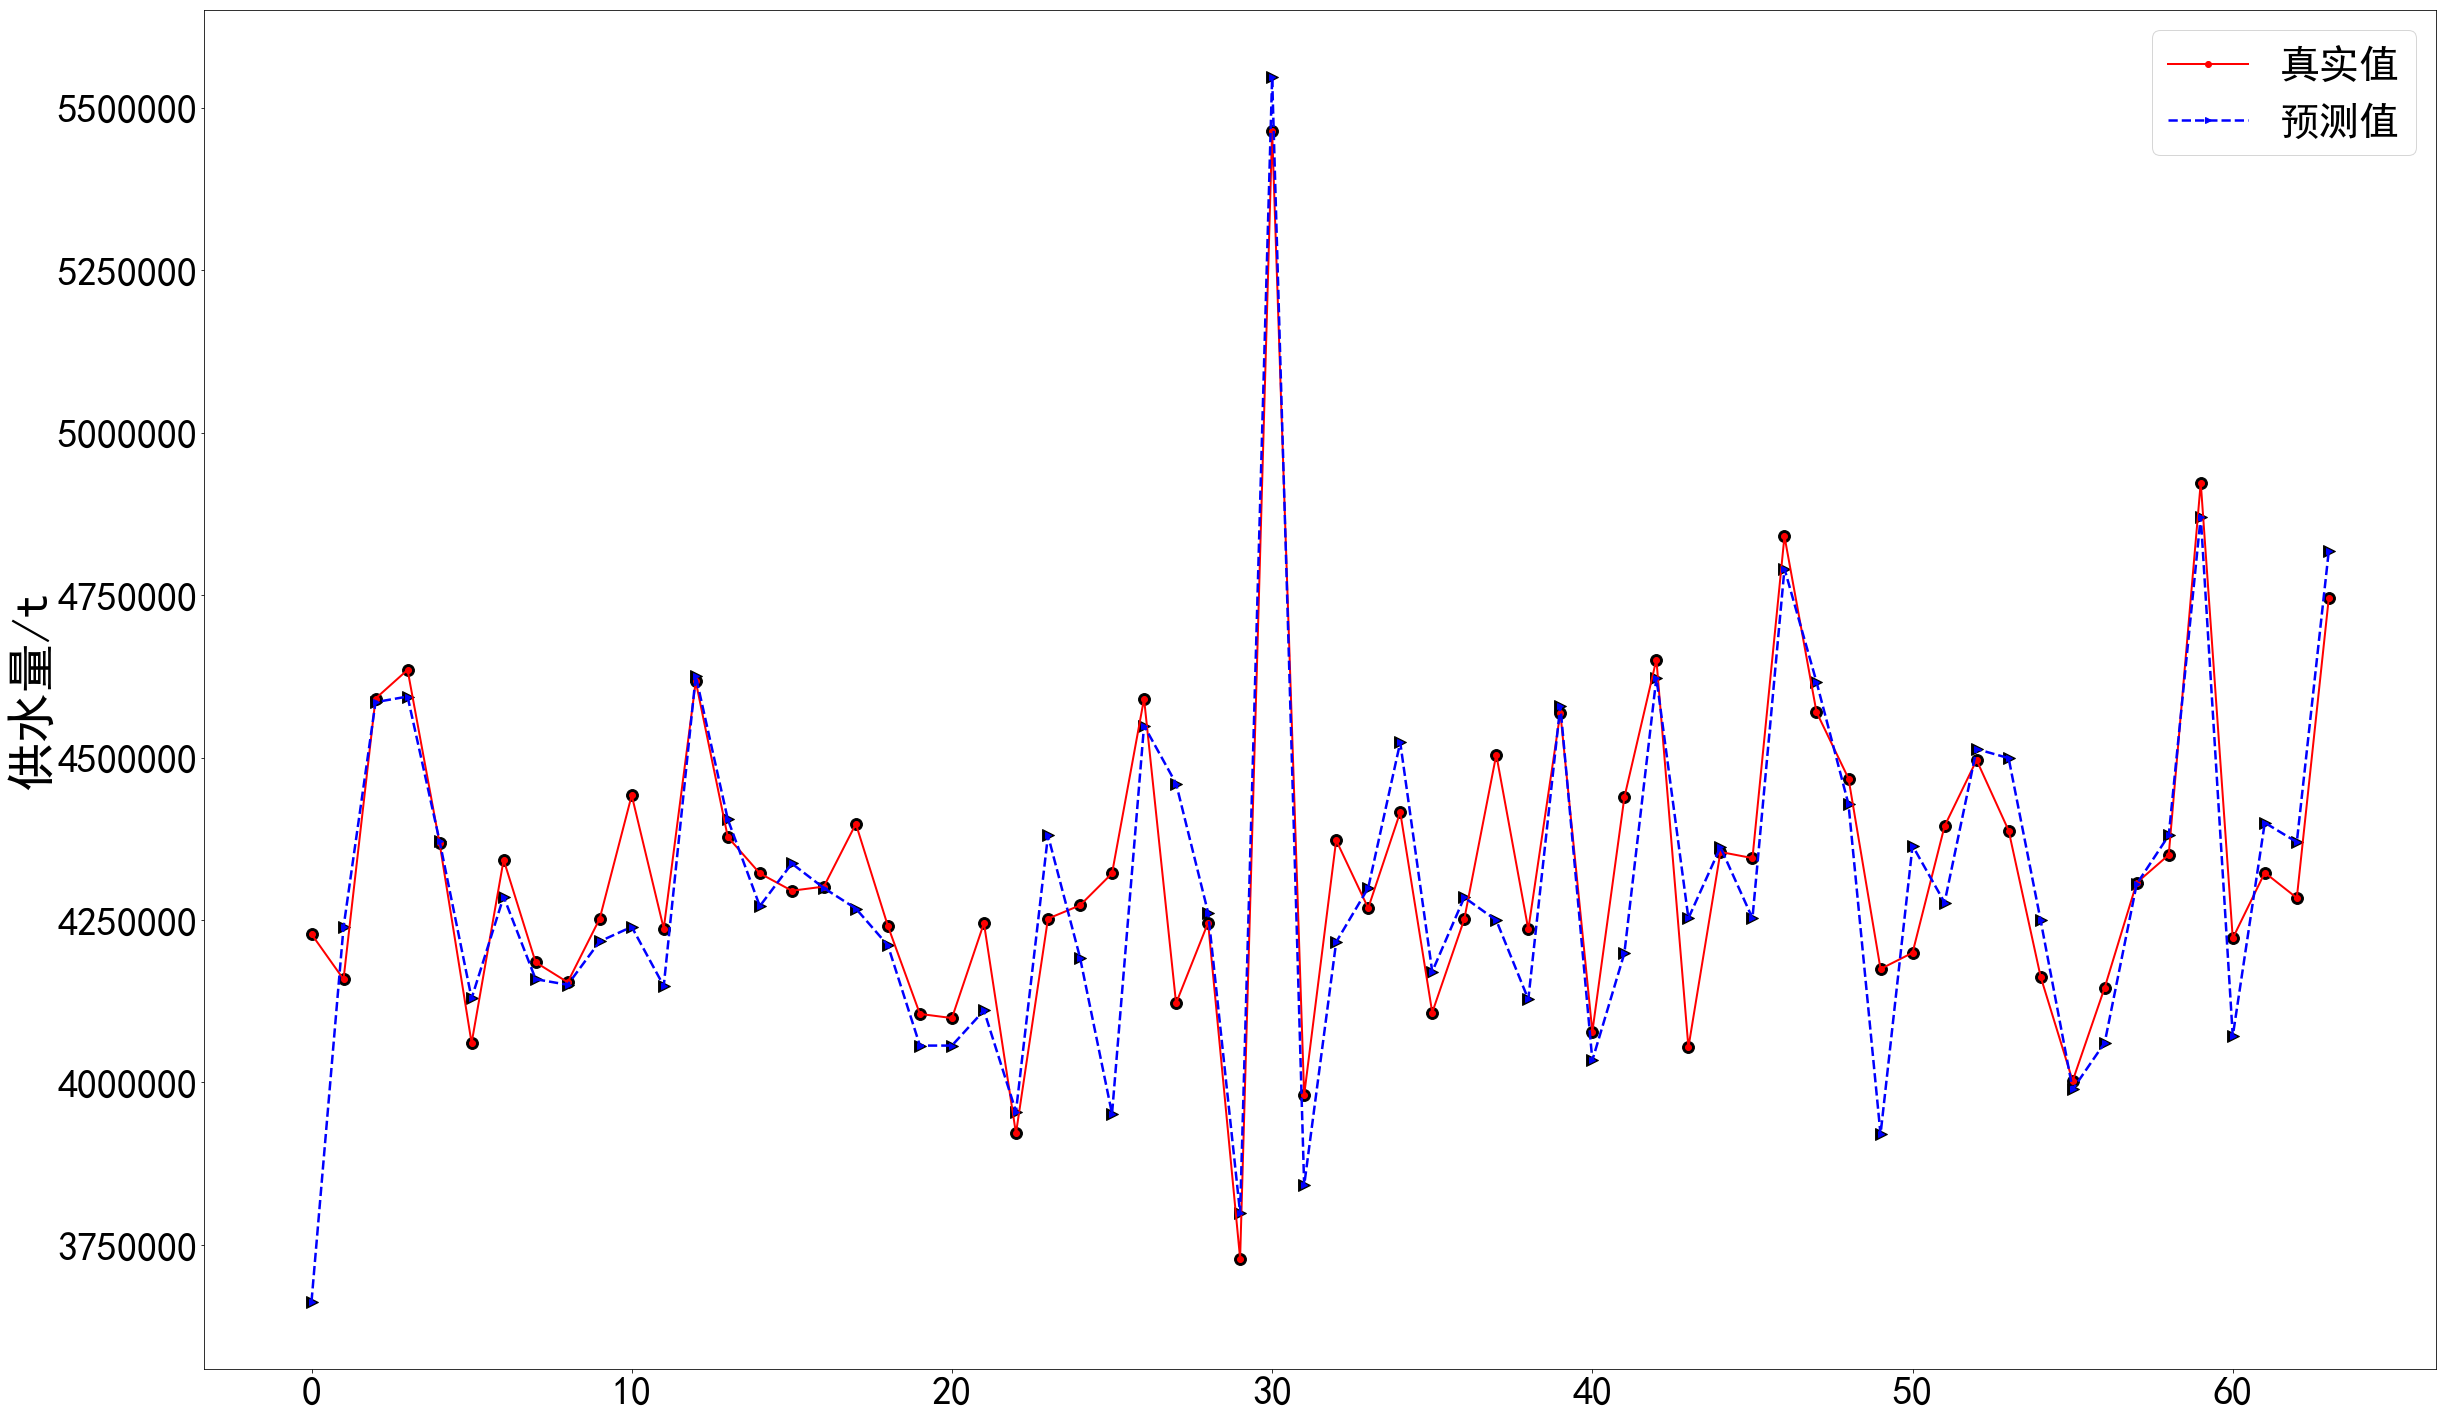

In [41]:
plt_model = DecisionTreeRegressor()
plt_model.fit(X_train,y_train)
y_new_pre = plt_model.predict(X_test)
fig1 = plt.figure(figsize=(40,25))
plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_new_pre,s= 140,color = 'black',marker = '>')
plt.plot(range(len(X_test)),y_test.values,'ro-',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_new_pre,'b>--',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.ylabel('供水量/t',size = 50)
plt.legend(prop={'size':40}) 
print(np.mean(abs(y_test-y_new_pre)))
print(np.mean(abs(y_test - y_new_pre)/y_test))

## SVR

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn import preprocessing
#re = SVR(kernel='poly')
#test_score = -cross_val_score(re, X_input, y, cv=10, scoring='neg_mean_absolute_error')
#print(np.mean(test_score))

c:\python3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
c:\python3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78409.92414245948
0.01765323920470278


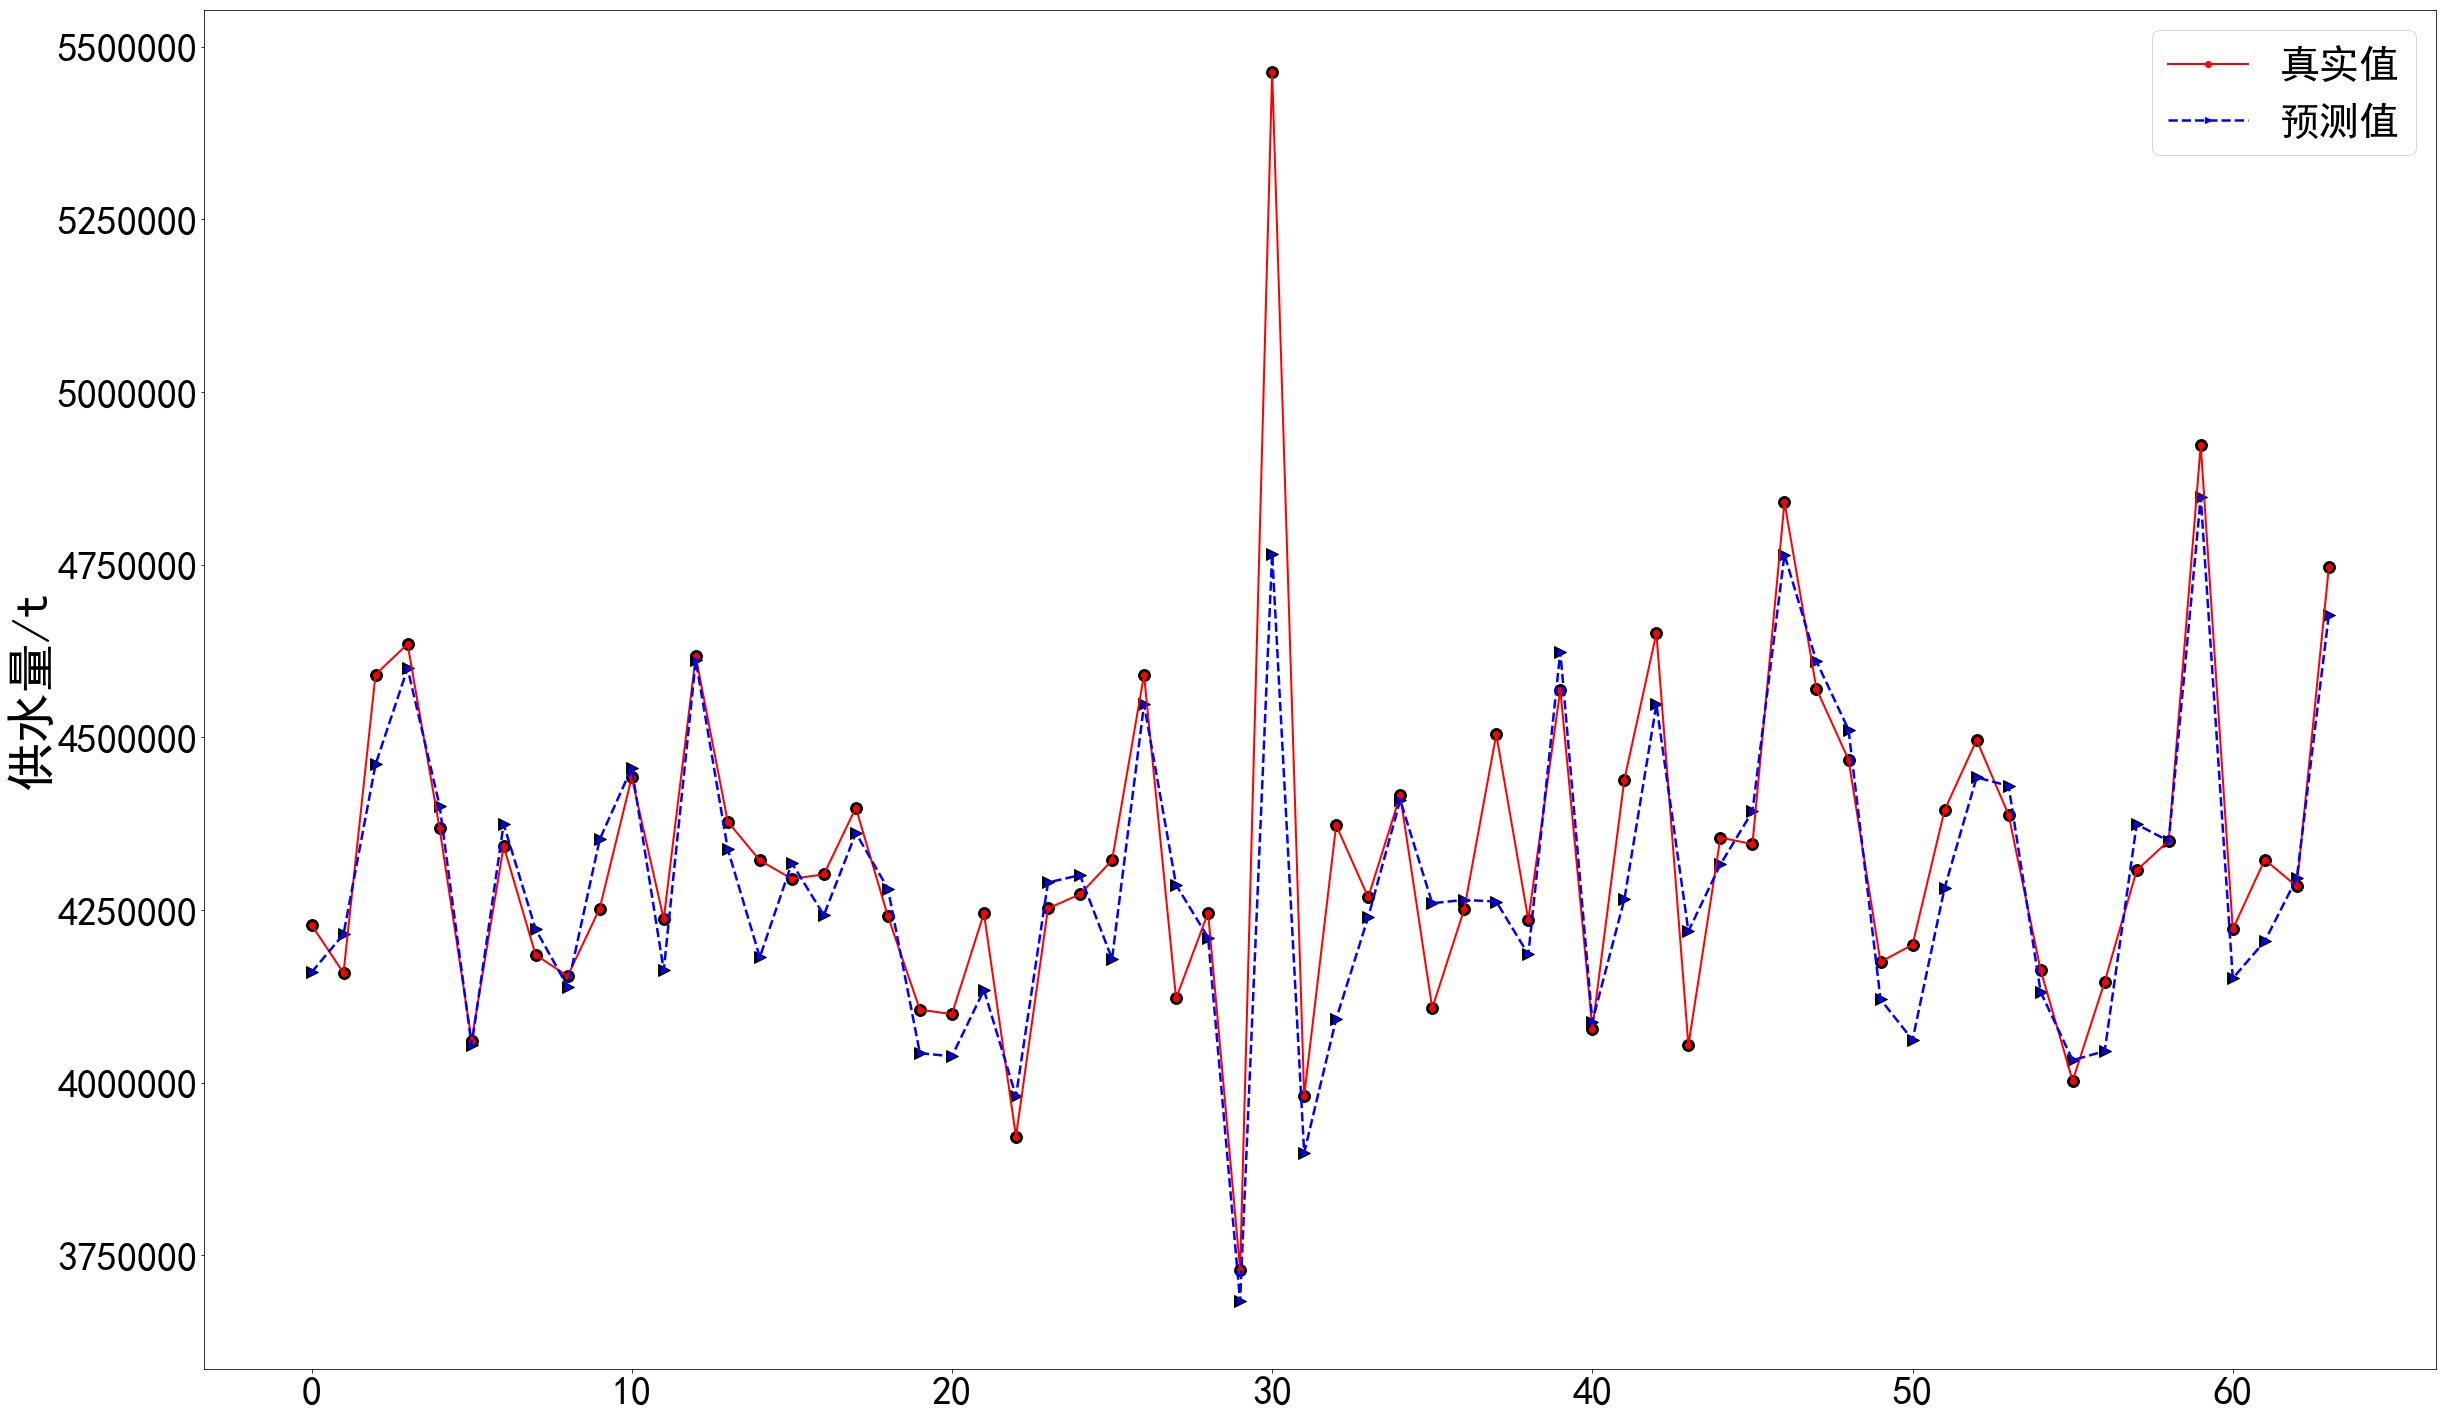

In [46]:
x_chart = StandardScaler()
y_chart = StandardScaler()
x_scaler = x_chart.fit_transform(pd.concat([X_train,X_test],axis = 0))
y_scaler = y_chart.fit_transform(y_train.reshape(-1,1))                                               
clf = SVR()
clf.fit(x_scaler[:len(X_train)],y_scaler)
y_pre = clf.predict(x_scaler[-len(X_test):])
plt.rcParams['figure.figsize'] = (40,25)
y_pre = y_chart.inverse_transform(y_pre)

plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_pre,s= 140,color = 'black',marker = '>')

plt.plot(range(len(X_test)),y_test,'ro-',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_pre,'b>--',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.ylabel('供水量/t',size = 50)
plt.legend(prop={'size':40}) 
print(np.mean(abs(y_test-y_pre)))
print(np.mean(abs(y_test-y_pre)/y_test))

## BP神经网络

In [47]:
import tensorflow as tf
inunits =  90
h1_units = 15
W1 = tf.Variable(tf.random_normal([inunits,h1_units],stddev = 0.1),name = 'w1')
b1 = tf.Variable(tf.zeros([h1_units]),name = 'b1')
W2 = tf.Variable(tf.zeros([h1_units,1]),name = 'w2')
b2 = tf.Variable(tf.zeros([1]),name = 'b2')
X = tf.placeholder(tf.float32,[None,inunits],name = 'X')
Y = tf.placeholder(tf.float32,[None,1],name = 'Y')
hidden1 = tf.matmul(X,W1) + b1
y_p = tf.matmul(hidden1,W2) + b2
loss = tf.reduce_mean(tf.reduce_sum(tf.abs(Y - y_p),reduction_indices=[1]))
train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)
init=tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for i in range(100000):
    _,l = sess.run([train_step,loss],feed_dict={X:X_train.values,Y:y_train.values.reshape(-1,1)})

In [48]:
y_pre = sess.run(y_p,feed_dict={X:X_test})

95433.8125
0.02241092259544776


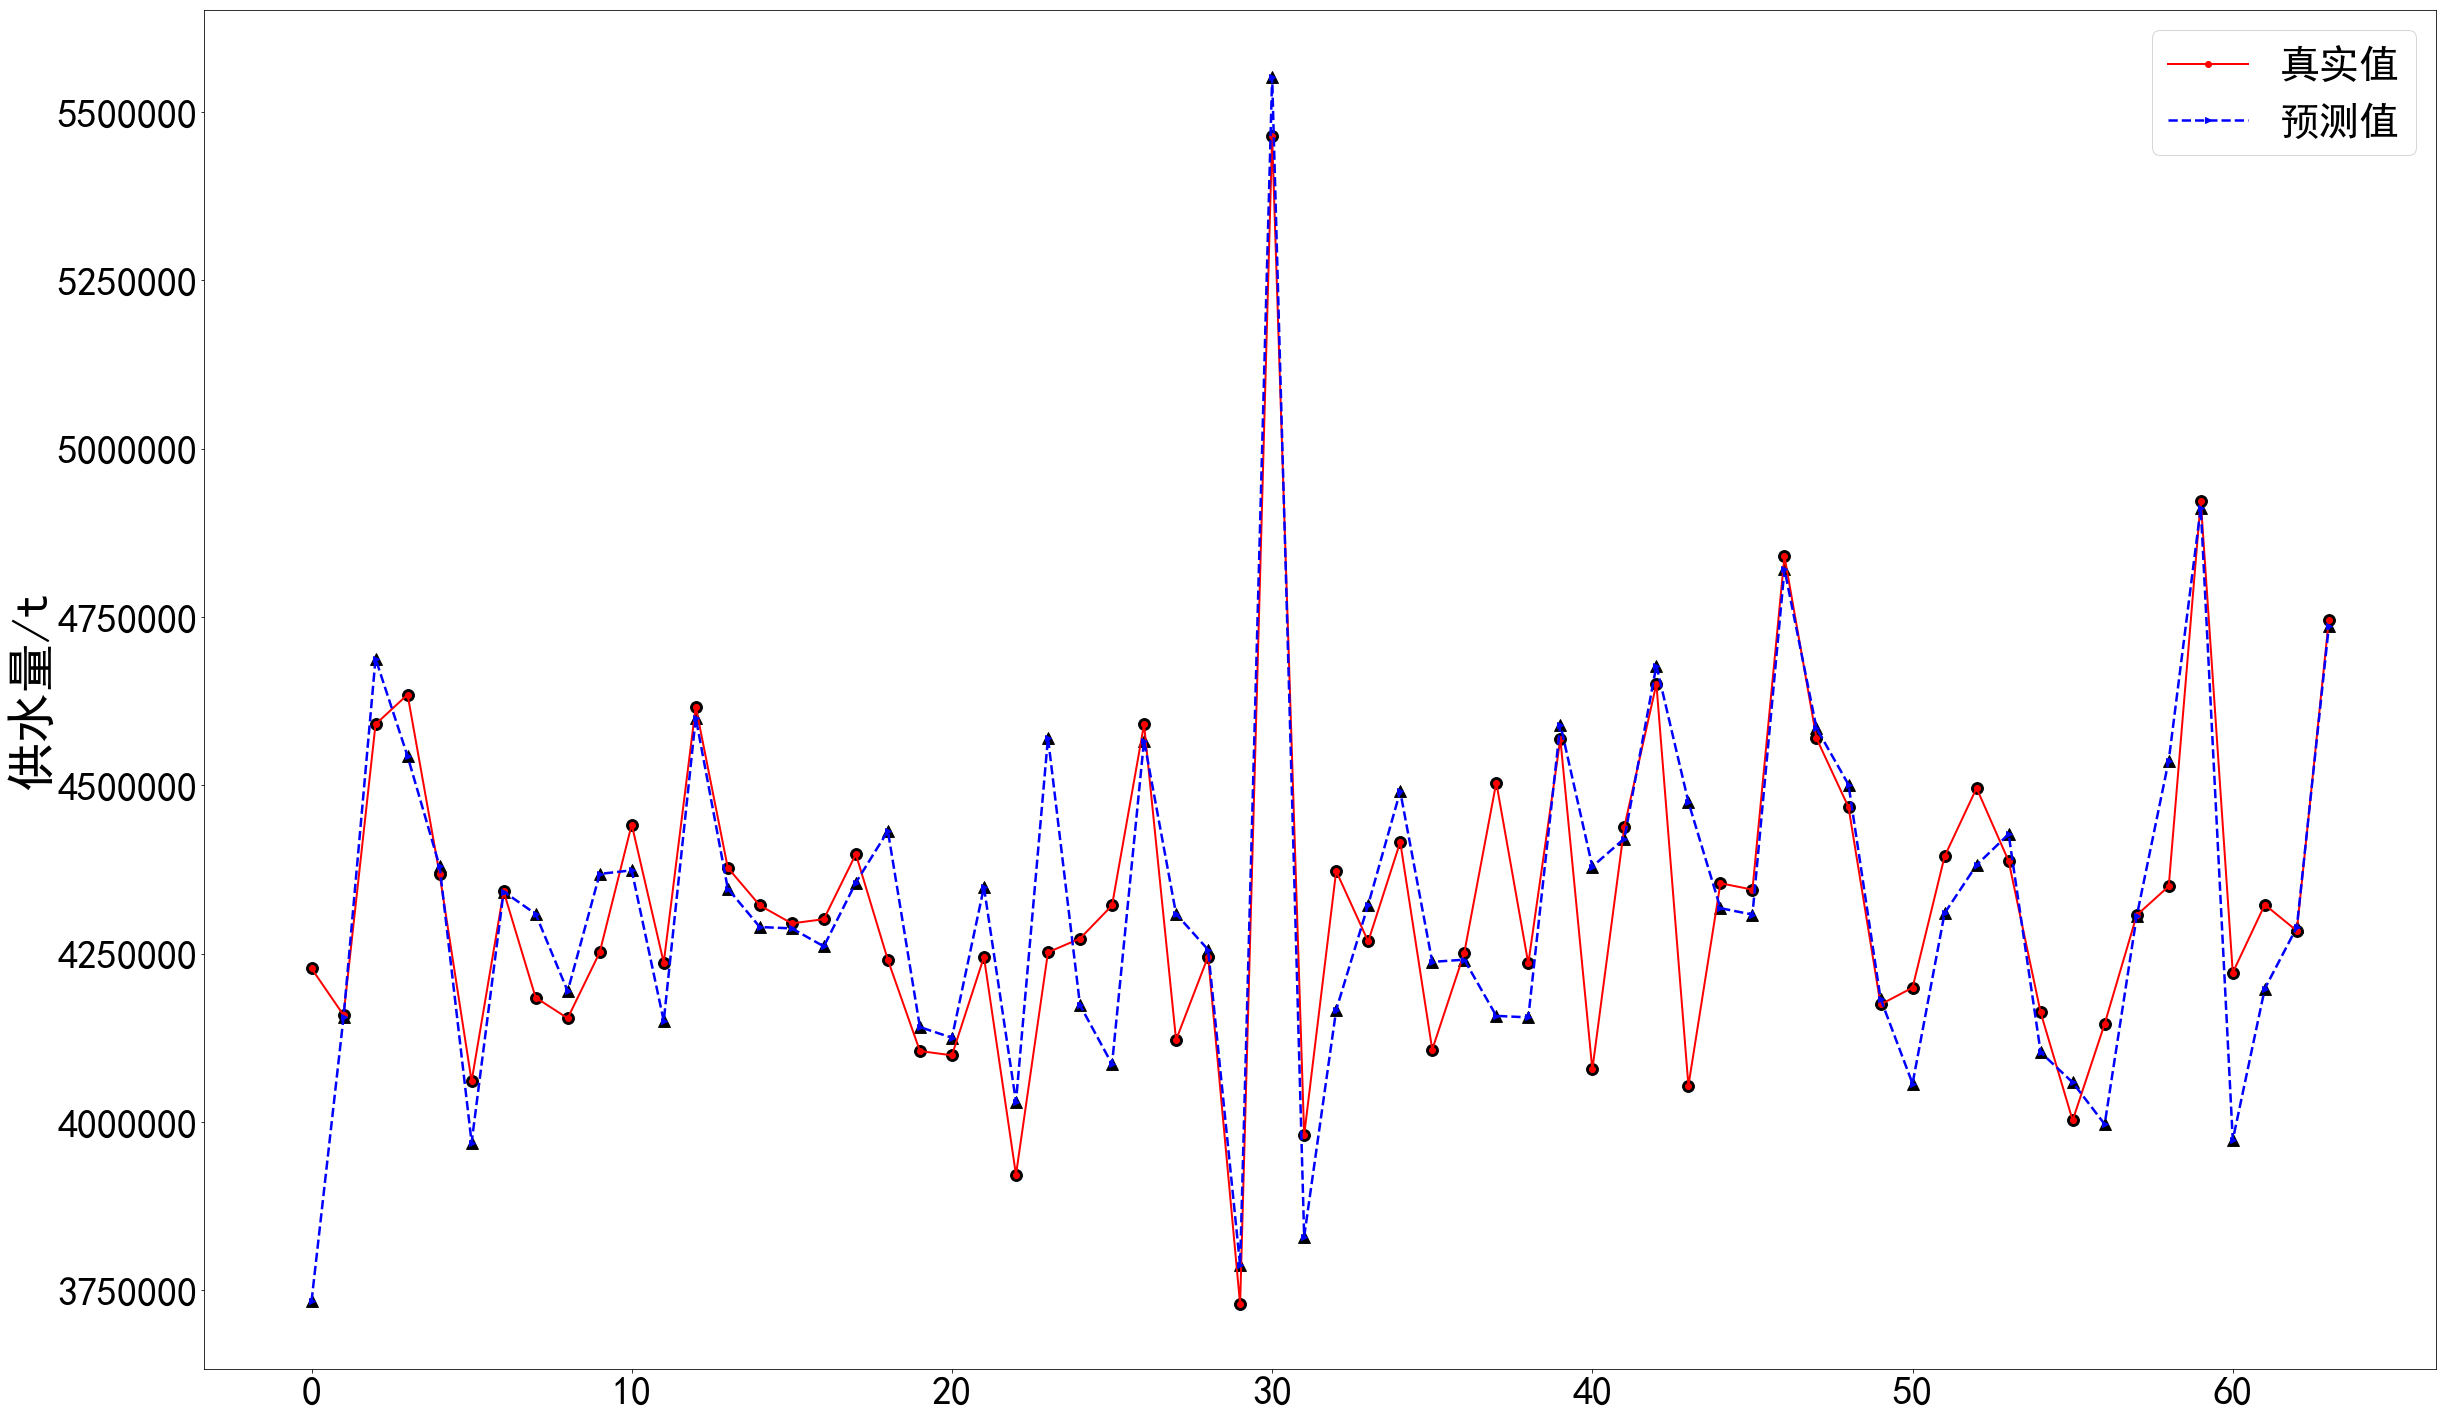

In [50]:
fig1 = plt.figure(figsize=(40,25))
plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_pre,s= 140,color = 'black',marker = '^')

plt.plot(range(len(X_test)),y_test,'o-',color = 'red',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_pre,'>--',color = 'blue',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.legend(prop={'size':40}) 
plt.ylabel('供水量/t',size = 50)
print(np.mean(abs(y_test-y_pre.reshape(-1))))
print(np.mean(abs(y_test-y_pre.reshape(-1))/y_test))

In [54]:
116820-72218

44602